# Actual Observed June Stock Prices

In [1]:
import pandas as pd 
import openpyxl

june = pd.read_excel('June Stock Prices.xlsx', engine = 'openpyxl', skiprows = 2)
june['Dates'] = pd.to_datetime(june['Dates'])
june.set_index('Dates', inplace = True)

print(june.head(3))

            AMZN US Equity  GOOG US Equity
Dates                                     
2024-06-03          178.34          174.42
2024-06-04          179.34          175.13
2024-06-05          181.28          177.07


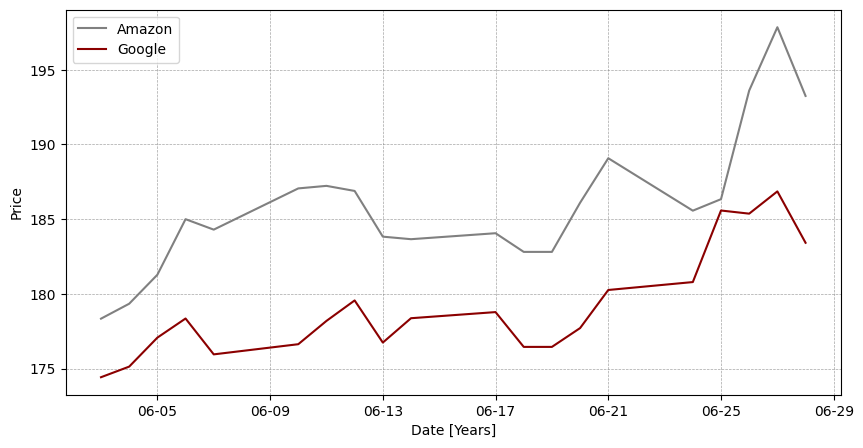

In [2]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

plt.style.use('default')
plt.figure(figsize = (10, 5))
plt.plot(june['AMZN US Equity'], label='Amazon', color = "grey")
plt.plot(june['GOOG US Equity'], label='Google', color = "darkred")

ax = plt.gca()
plt.xlabel('Date [Years]')
plt.ylabel('Price')
date_form = DateFormatter('%m-%d')
plt.gca().xaxis.set_major_formatter(date_form)
plt.legend()
plt.savefig('ActualJuneStocks.png')
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5, color = 'grey', alpha = 0.7)
plt.show()

In [3]:
import numpy as np

ParamEstimation = pd.read_excel('ParamEstimation.xlsx')
np.round(ParamEstimation, decimals = 2)

max_index      = ParamEstimation["Log-likelihood Value"].idxmax()
optimal_params = ParamEstimation.loc[max_index]

mu    = np.array([optimal_params[1:3]])
kappa = np.array([optimal_params[4:6]])
theta = np.array([optimal_params[6:8]])
xi    = np.array([optimal_params[8:10]])

rho_ss  = optimal_params[9]
rho_sv1 = optimal_params[10]
rho_sv2 = optimal_params[11]

corr_matrix = np.array([[1       , rho_ss  , rho_sv1,  0     ],
                        [rho_ss  , 1       , 0      , rho_sv2],
                        [rho_sv1 , 0       , 1      , 0      ],
                        [0       , rho_sv2 , 0      , 1      ]])
sigma = xi
rho   = rho_ss

C:\Users\masan\AppData\Local\Temp\ipykernel_12396\528085476.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_ss  = optimal_params[9]
C:\Users\masan\AppData\Local\Temp\ipykernel_12396\528085476.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_sv1 = optimal_params[10]
C:\Users\masan\AppData\Local\Temp\ipykernel_12396\528085476.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho_sv2 = optimal_params[11]


In [4]:
from scipy.stats import norm

def payoff(path):   # To get the payoff HT
  difference = path[0] - path[1]
  return np.maximum(difference, 0)

def Phi(x):
    return norm.cdf(x)

def d1(St, Tt, sigmas, rho):
    S = St[0] / St[1]
    cov = np.prod(sigmas) * rho
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d1 = (np.log(S) + 0.5 * Tt * sig ** 2) / (sig * np.sqrt(Tt))
    return _d1

def d2(St, Tt, sigmas, rho):
    cov = np.prod(sigmas) * rho
    _d1 = d1(St, Tt, sigmas, rho)
    sig = np.sqrt(np.sum(np.square(sigmas)) - 2 * cov)
    _d2 = _d1 - sig * np.sqrt(Tt)
    return _d2

def price(path, Tt, sigmas, rho):
  price = path[0] * Phi(d1(path, Tt, sigmas, rho)) - path[1] * Phi(d2(path, Tt, sigmas, rho))
  return price

In [5]:
S1 = june['AMZN US Equity'].values
S2 = june['GOOG US Equity'].values
tau = np.linspace(len(S1)/365, 0, len(S1))
paths = np.column_stack((S1, S2))
delta_S = np.diff(paths, axis=0)  

Ht = [price(paths[i], tau[i], sigma, rho) for i in range(len(paths)-1)]  
Ht.append(payoff(paths[-1]))           # Set final value of H_t as the payoff at maturity

## Black-Scholes Hedge

In [6]:
# Black-Scholes Hedge!!!!
V = Ht[0] 
VtBS = [V]  

for i in range(len(delta_S)):
    Tt = tau[i]
    St = paths[i]

    phi1 = Phi(d1(St, Tt, sigma, rho))   # Hedge ratio for S1
    phi2 = -Phi(d2(St, Tt, sigma, rho))  # Hedge ratio for S2
    V += phi1*delta_S[i, 0] + phi2*delta_S[i, 1]
    VtBS.append(V)
print('PNL BS:', V - payoff(paths[-1]))

PNL BS: 3.9890680611783296


## Neural Network Hedge

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HedgingNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(HedgingNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], hidden_size[4])
        self.fc6 = nn.Linear(hidden_size[4], hidden_size[5])
        self.fc7 = nn.Linear(hidden_size[5], output_size)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = getattr(torch.nn.functional, self.activation_fn[0])(self.fc1(x))
        x = getattr(torch.nn.functional, self.activation_fn[1])(self.fc2(x))
        x = getattr(torch.nn.functional, self.activation_fn[2])(self.fc3(x))
        x = getattr(torch.nn.functional, self.activation_fn[3])(self.fc4(x))
        x = getattr(torch.nn.functional, self.activation_fn[4])(self.fc5(x))
        x = getattr(torch.nn.functional, self.activation_fn[5])(self.fc6(x))
        x = torch.tanh(self.fc7(x))  # Final layer activation remains tanh
        return x

def regularization_loss(model, reg_type, lambda_reg): # regularisation
    reg_loss = 0.0
    if reg_type == 'l1':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(torch.abs(param))
    elif reg_type == 'l2':
        for name, param in model.named_parameters():
            if 'weight' in name:
                reg_loss += torch.sum(param ** 2)
    return lambda_reg * reg_loss

def custom_loss(one_day_pl, delta_Ht, model, reg_type, lambda_reg):
    oneDayPL = torch.stack(one_day_pl).unsqueeze(1)
    mse_loss = F.mse_loss(oneDayPL, delta_Ht)
    reg_loss = regularization_loss(model, reg_type, lambda_reg)
    total_loss = mse_loss + reg_loss
    
    return total_loss

S1_tensor = torch.tensor(S1, dtype=torch.float32).reshape(-1, 1)
S2_tensor = torch.tensor(S2, dtype=torch.float32).reshape(-1, 1)
tau_tensor = torch.tensor(tau, dtype=torch.float32).reshape(-1, 1)
Ht_tensor = torch.tensor(Ht, dtype=torch.float32).reshape(-1, 1)
inputs    = torch.cat((S1_tensor, S2_tensor, tau_tensor), dim=1)

In [8]:
best_hidden_size   = [199, 298, 285, 373, 429, 124]
best_activation_fn = ['sigmoid', 'sigmoid', 'relu', 'sigmoid', 'tanh', 'tanh']
best_lambda_reg    = 0.03870965343251043
best_reg_type      = 'l2'

hedgeNN = HedgingNet(input_size=3, hidden_size=best_hidden_size, output_size=2, activation_fn=best_activation_fn)
hedgeNN.load_state_dict(torch.load('best_model.pth'))
hedgeNN.eval()

C:\Users\masan\AppData\Local\Temp\ipykernel_12396\1955395625.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hedgeNN.load_state_dict(torch.load('best_model.pth'))


HedgingNet(
  (fc1): Linear(in_features=3, out_features=199, bias=True)
  (fc2): Linear(in_features=199, out_features=298, bias=True)
  (fc3): Linear(in_features=298, out_features=285, bias=True)
  (fc4): Linear(in_features=285, out_features=373, bias=True)
  (fc5): Linear(in_features=373, out_features=429, bias=True)
  (fc6): Linear(in_features=429, out_features=124, bias=True)
  (fc7): Linear(in_features=124, out_features=2, bias=True)
)

In [9]:
V_NN = Ht[0]
VtNN = [V_NN]  
with torch.no_grad():
    outputs = hedgeNN(inputs)  
    phi1_nn, phi2_nn = outputs[:, 0], outputs[:, 1]
    
for i in range(len(delta_S)):
    V_NN += phi1_nn[i].item() * delta_S[i, 0] + phi2_nn[i].item() * delta_S[i, 1]
    VtNN.append(V_NN)
print('PNL NN:', V_NN - Ht[-1])

PNL NN: 1.5161051605352043


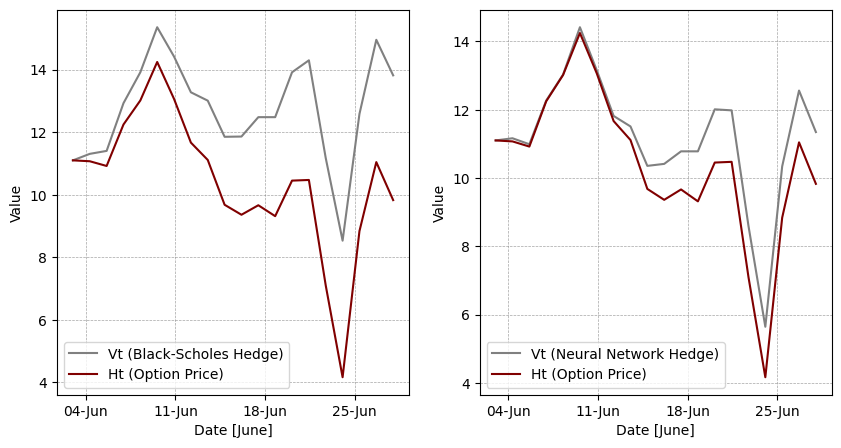

In [10]:
import matplotlib.dates as mdates
from datetime import datetime

end_date = datetime(2024, 6, 28)
start_date = datetime(2024, 6, 3)
date_range = pd.date_range(start=start_date, end=end_date, periods=len(VtBS))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(date_range, VtBS, label='Vt (Black-Scholes Hedge)', color='grey')
plt.plot(date_range, Ht, label='Ht (Option Price)', color='maroon')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.xlabel('Date [June]')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  

plt.subplot(1, 2, 2)
plt.plot(date_range, VtNN, label='Vt (Neural Network Hedge)', color='grey')
plt.plot(date_range, Ht, label='Ht (Option Price)', color='maroon')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.xlabel('Date [June]')
plt.ylabel('Value')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))  
plt.savefig('junehedge.png')
plt.show()
